IndexError: list index out of range

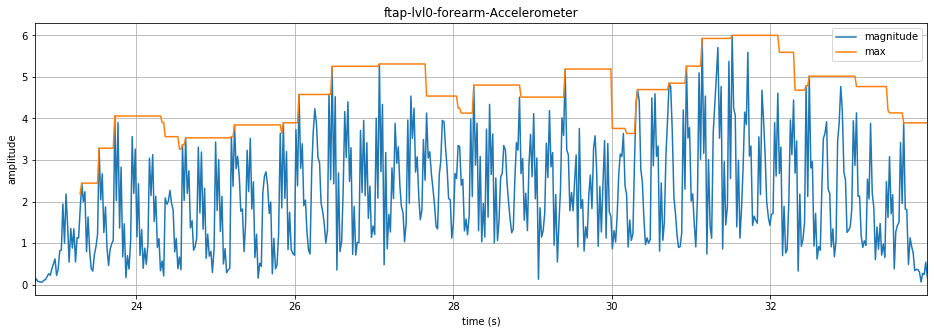

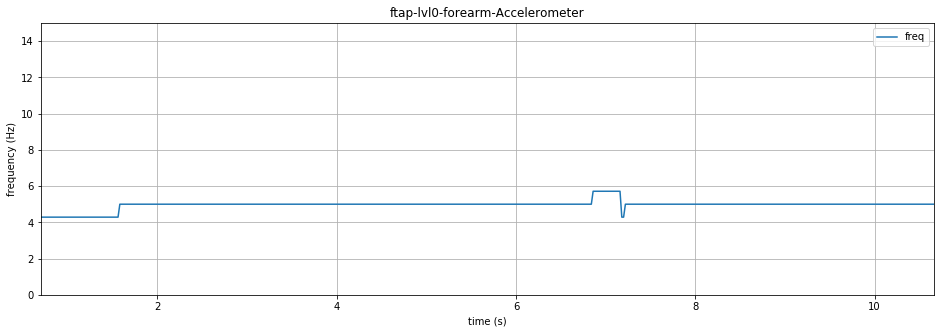

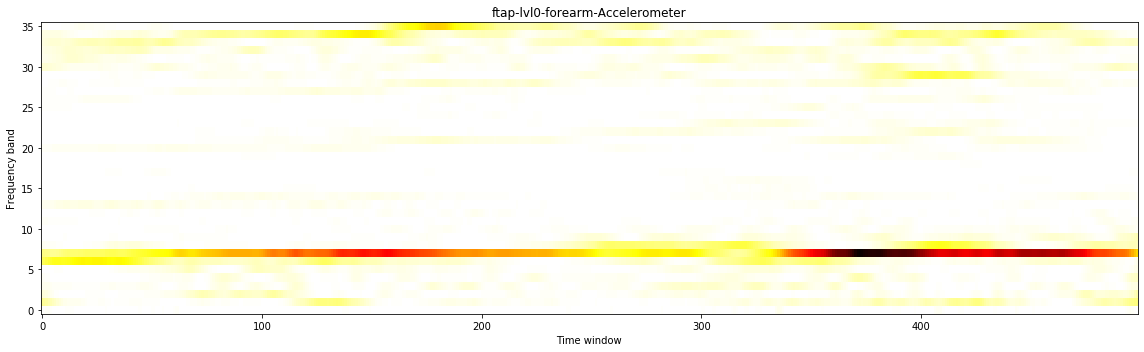

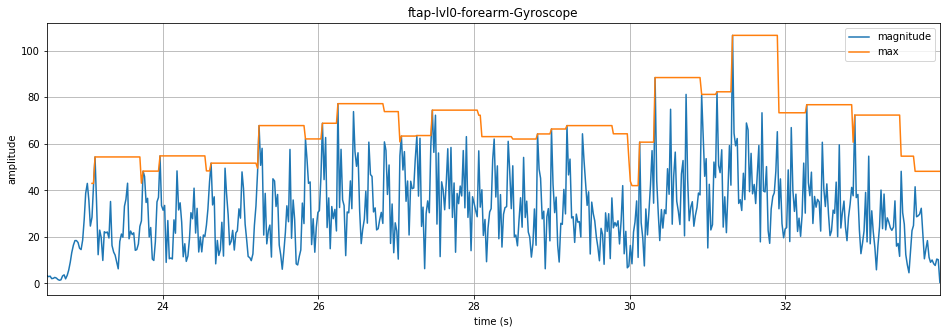

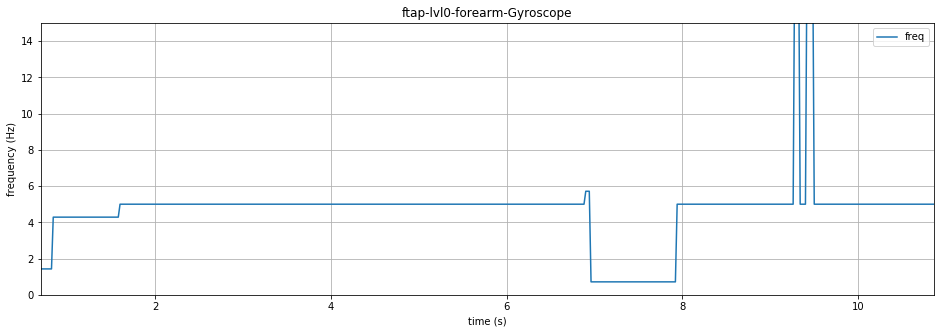

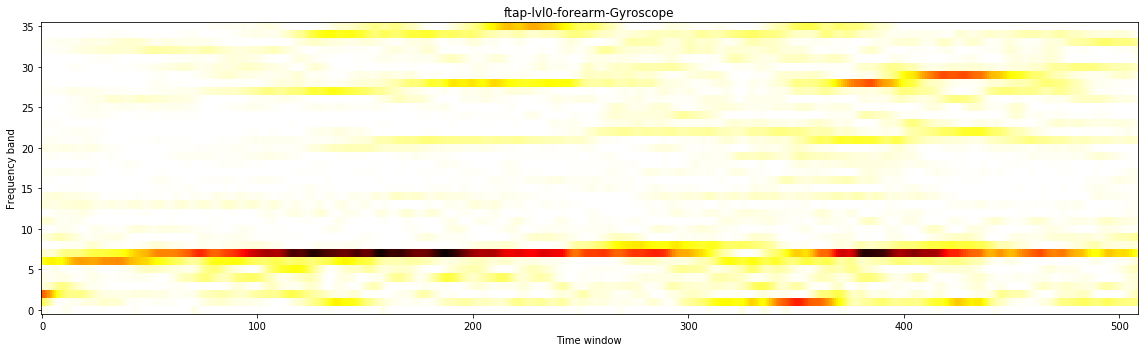

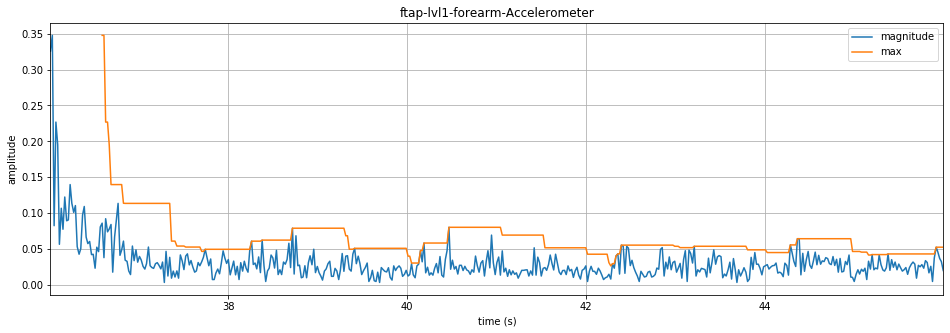

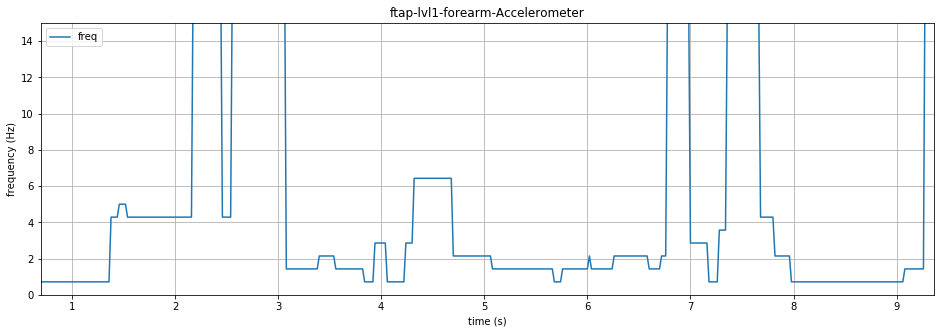

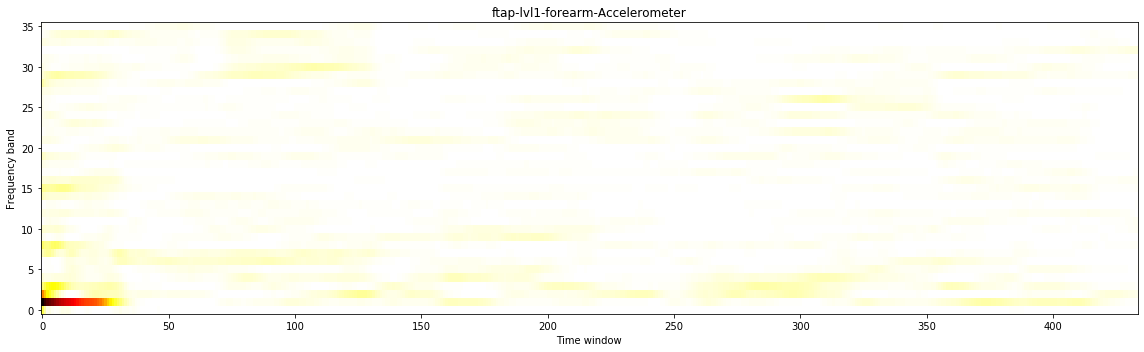

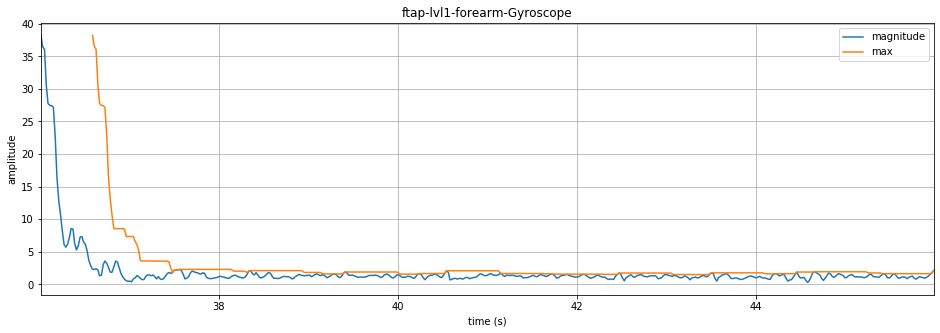

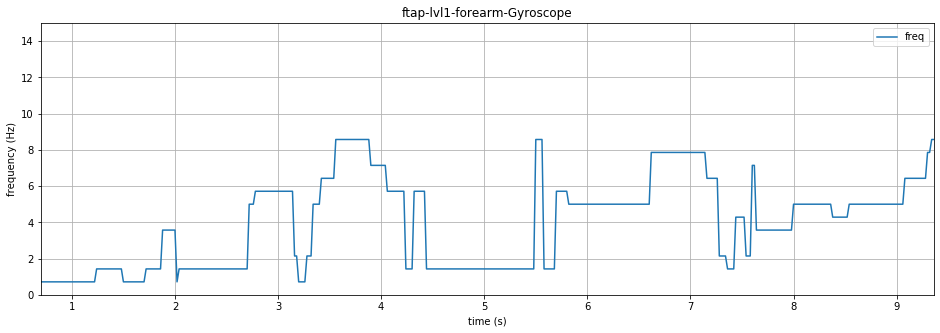

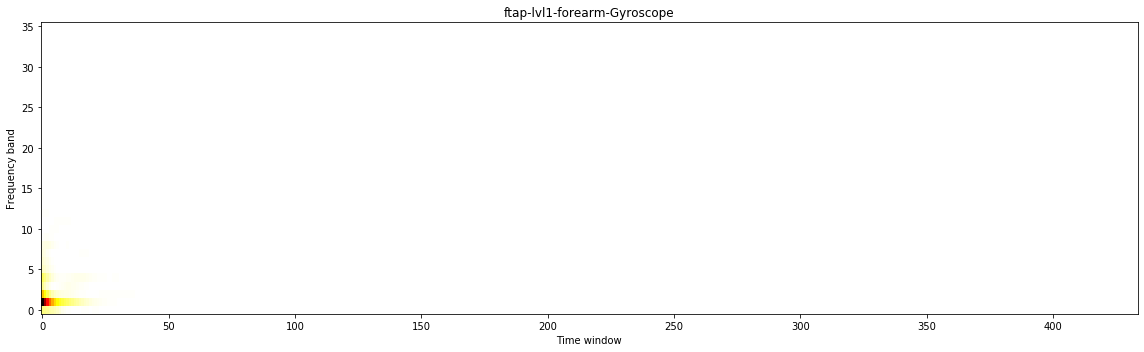

In [20]:
from os import listdir
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def cal_mean(c):
    # calculate mean of 3 different tries
    return np.around(np.add.reduceat(c, np.arange(0, len(c), 3))/3,3)

def plt_individual_graphs(df, df_, spectrogram, title):
    # plot magnitude graph
    ax1=df.plot(x='elapsed (s)',y=['magnitude','max'],
                grid=True,figsize=(16,5),
                title=title)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('amplitude')

    # plot frequency over time
    ax2=df_.plot(x='time',y='freq',
             grid=True,figsize=(16,5),ylim=[0,15],
             title=title)
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('frequency (Hz)')
    
    # plot spectrogram
    plt.figure(figsize=(16,5))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title(title)
    plt.ylabel('Frequency band')
    plt.xlabel('Time window')
    plt.tight_layout()
    
def cal_magnitude(df, file, window):
    # combine triaxial data into one singular magnitude data
    if 'Accelerometer' in file:
        df['x'] = df.loc[window-1:,'x-axis (g)']-df['x-axis (g)'].rolling(window).mean()[window-1:]
        df['y'] = df.loc[window-1:,'y-axis (g)']-df['y-axis (g)'].rolling(window).mean()[window-1:]
        df['z'] = df.loc[window-1:,'z-axis (g)']-df['z-axis (g)'].rolling(window).mean()[window-1:]
        df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
        df['magnitude'] = (df['magnitude'].apply(math.sqrt))*9.81
        
    elif 'Gyroscope' in file:
        df['x'] = df.loc[window-1:,'x-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['y'] = df.loc[window-1:,'y-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['z'] = df.loc[window-1:,'z-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
        df['magnitude'] = df['magnitude'].apply(math.sqrt)
        
    return df

# MAIN FUNCTION
def main(path='/', window=3, truncate=None, info=None, counter=[0,0,0,0], axes=[]):
    filenames = [filename for filename in listdir(path) if filename.endswith('.csv')]
    
    for i in range(len(filenames)):
        file = filenames[i]
        title = file.split('_')[0]

        # extract dataframe
        df = pd.read_csv(path + file)

        # combine triaxial data into one singular magnitude data
        df = cal_magnitude(df, file, window)

        # truncate signal beyond start and end times
        if truncate is not None:
            df = df[(df['elapsed (s)'] <= truncate[i][1]) & (df['elapsed (s)'] >= truncate[i][0])]
            df.reset_index(inplace=True)

        # extract umbrella curve
        df['max'] = df['magnitude'].rolling(30).max()
        
        # calculate rolling frequency
        freqs, times, spectrogram = signal.spectrogram(df['magnitude'].values, fs=50.0, nperseg=70, noverlap=70-1)
        df_ = pd.DataFrame({'time':times, 'freq':[freqs[i] for i in np.argmax(spectrogram,0)]})
        df_['max'] = df_['freq'].rolling(30).max()

        # gather information on amplitude
        stats = df.describe().loc[:,['max','magnitude']].T
        # gather information on frequency
        stats_ = df_.describe().loc[:,['max','freq']].T
        
        # append into dataframe
        info = info.append({
            'test': title,
            'mean_amp': stats['mean'][0].round(3),
            'std_amp': stats['std'][1].round(3),
            'mean_freq': stats_['mean'][0].round(3),
            'std_freq': stats_['std'][1].round(3)
        }, ignore_index=True)
        
#         count_col = 0
#         count_row = 0
#         state = False
#         for i in range(len(df)):
#             if (df['max'][i] < 3) and (state):
#                 count_col += 1
#                 state = False
#             elif df['max'][i] >= 3:
#                 if (~state):
#                     state = True
#                     df[str(count_col)] = np.nan
#                 df[str(count_col)][i] = df['max'][i]
#                 count_row += 1
        
#         # ONLY UNCOMMENT WHEN PLOTTING GRAPHS
        plt_individual_graphs(df, df_, spectrogram, title+'-'+file.split('_')[4])
#         counter = plt_bubble_amp(df, file, counter, axes)
#         counter = plt_bubble_freq(df_, file, counter, axes)
    
    return info, axes

info = pd.DataFrame(columns=['test','mean','std'])

# real data
info, axes = main(path='../../../Data/Patient001-2019-12-05/ftap-forearm/',
                  truncate = [(22.7,34),(22.5,34),(36,46),(36,46)],
                  info=info)